# MODIS

`wxee` is designed for processing weather data, but it can also be useful for remote sensing data. In this example, we'll look at how `wxee` can work with data from the MODIS sensor.

## Setup

In [ ]:
!pip install wxee

In [1]:
import ee
import wxee

ee.Authenticate()
ee.Initialize() 

## Downloading MODIS to xarray

We'll start by loading 6 months of MODIS Terra 8-day reflectance images and selecting just the RGB bands.

In [2]:
ts = wxee.TimeSeries("MODIS/006/MOD09A1").filterDate("2020-03", "2020-09")
ts = ts.select(["sur_refl_b01", "sur_refl_b04", "sur_refl_b03"])

ts.describe()

MODIS/006/MOD09A1
	Images: 23
	Start date: 2020-03-05 00:00:00 UTC
	End date: 2020-08-28 00:00:00 UTC
	Mean interval: 8.00 days


MODIS imagery is unbounded, so we need to specify a region when we convert it to an `xarray.Dataset`. We'll select Madagascar from a collection of country polygons.

In [3]:
countries = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0")
madagascar = countries.filterMetadata("ADM0_NAME", "equals", "Madagascar")

Now we'll download the `TimeSeries` collection to an `xarray.Dataset`.

In [4]:
ds = ts.wx.to_xarray(region=madagascar.geometry().bounds(), scale=10_000, crs="EPSG:29702")

## Visualizing in RGB

Visualizing single band data from the `Dataset` is easy. Below, we'll plot median red reflectance over the time series.

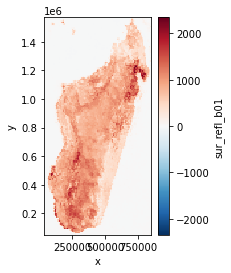

In [5]:
ds.sur_refl_b01.median("time").plot(size=4, aspect=0.6)

Since we have red, green, and blue reflectance data, we probably want an RGB output. That takes a little more preparation.

`wxee` downloads each image band as a separate variable and combines them into a `Dataset`. For plotting in RGB, we instead need a `DataArray` with the bands as coordinates instead of variables.

In [6]:
da = ds.to_array()

MODIS data is represented in scaled surface reflectance values which can be very large numbers. For RGB plotting, values have to be in the range of 0 to 1. Below we'll scale the array by an arbitrary amount and clip it to that range.

In [7]:
viz = (da / 2500).clip(0, 1)

Finally, we're ready to visualize our time series in full RGB color!

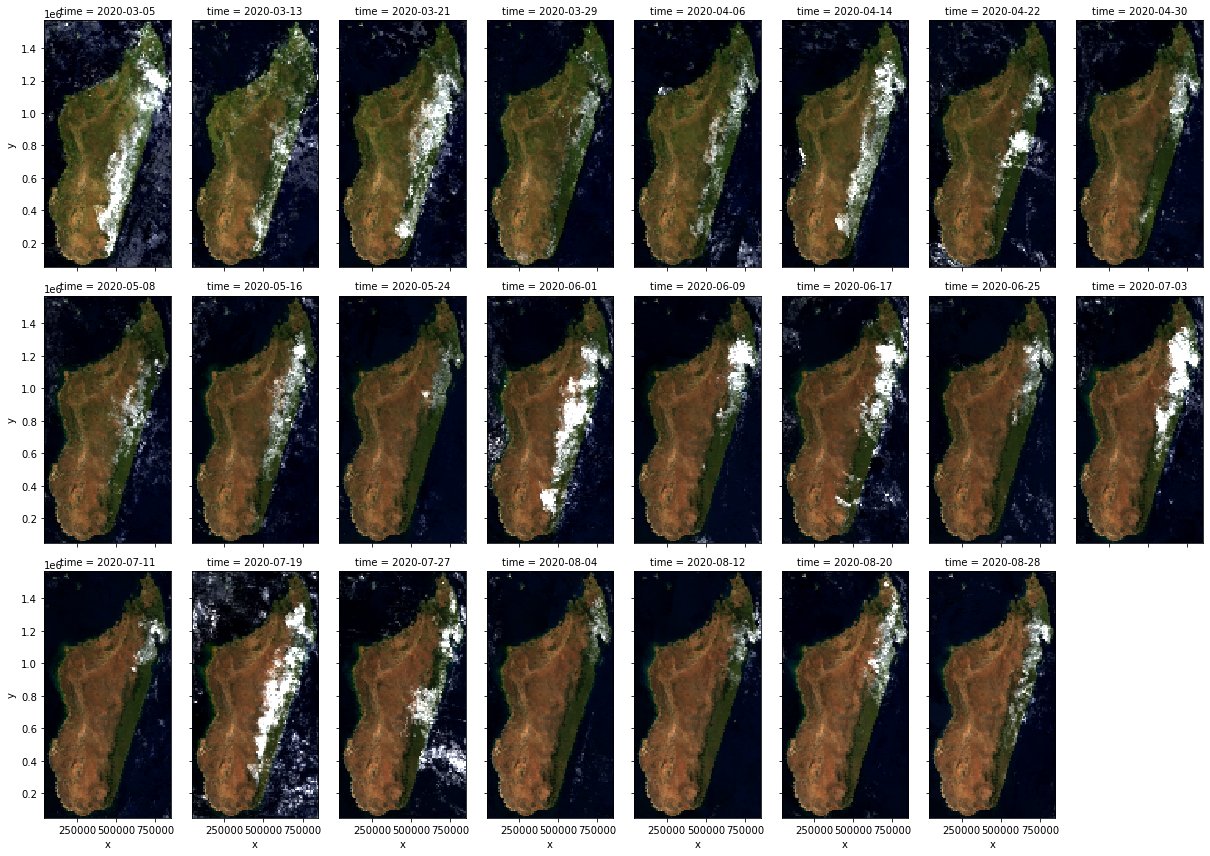

In [8]:
viz.plot.imshow(col="time", col_wrap=8, size=4, aspect=0.5)